# 分位点回帰

分位点$\tau$における条件付分位関数を

$$
Q_\tau(y_i | X_i) = F_y^{-1}(\tau | X_i)
$$

と表す。ここで$F_y^{-1}(\tau | X_i)$は$y$において$X_i$に条件づけられた$y_i$の分布関数である（$F_y^{-1}(\tau | X_i) = \inf \{ y: F_y(y|X_i) \geq \tau \}$）。

例えば$\tau = 0.1$のとき、$Q_\tau(y_i | X_i)$は$y_i$の下位10分位である。


標準的な回帰モデルは二乗誤差$(y_i - m(X_i))^2$の和や期待値を最小化するようにモデル$m(X_i)$を学習して条件付き期待値$E(y_i|X_i)$を予測する

$$
\newcommand{\argmin}{\mathop{\rm arg~min}\limits}
E(y_i|X_i) = \argmin_{m(X_i)}
E\big[ (y_i - m(X_i))^2 \big]
$$

**分位点回帰** （quantile regression）モデルはpinball loss$\rho_{\tau}(y_i - q(X_i))$の和や期待値を最小化するようにモデル$q(X_i)$を学習させ、条件付き分位関数$Q_{\tau}(y_i|X_i) = F^{-1}_y(\tau|X_i)$を予測する

$$
Q_{\tau}(y_i|X_i) = \argmin_{q(X_i)} 
E\big[ \rho_{\tau}(y_i - q(X_i)) \big]
$$



pinball lossは $\tau$-tiled absolute value function や 検定関数（check function）とも呼ばれる（グラフを描くとチェックマークに似てるため）

$$
\rho_{\tau} (x) = \big(\tau - \mathbb{1}(x \leq 0) \big) x
$$

あるいは

$$
\rho_{\tau} (x) =
\begin{cases}
(\tau - 1) x & \text{ if } x \leq 0\\
\tau x & \text{ if } x > 0\\
\end{cases}
$$

と書かれる

:::{margin}

$$
\rho_{\tau} (x) = \big(\tau - \mathbb{1}(x \leq 0) \big) x
$$

は

$x \leq 0$のときは

$$
\big(\tau - \mathbb{1}(x \leq 0) \big) x
= (\tau - 1) x
$$

となり、

$x > 0$のときは

$$
\big(\tau - \mathbb{1}(x \leq 0) \big) x
= (\tau - 0) x = \tau x
$$

となるので、

$$
\rho_{\tau} (x) =
\begin{cases}
(\tau - 1) x & \text{ if } x \leq 0\\
\tau x & \text{ if } x > 0\\
\end{cases}
\\
= \big(\tau - \mathbb{1}(x \leq 0) \big) x
$$

:::

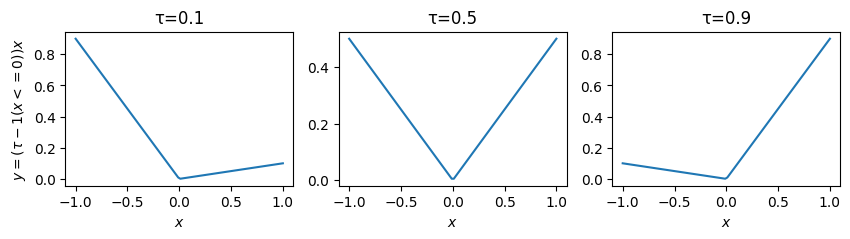

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def pinball_loss(x, tau):
    return (tau - 1 * (x <= 0)) * x

x = np.linspace(-1, 1, 100)
fig, axes = plt.subplots(figsize=[10, 2], ncols=3)
for i, tau in enumerate([0.1, 0.5, 0.9]):
    y = pinball_loss(x, tau=tau)
    axes[i].plot(x, y)
    if i == 0:
        axes[i].set(title=f"τ={tau}", xlabel=r"$x$", ylabel=r"$y = (\tau - 1(x <= 0)) x$")
    else:
        axes[i].set(title=f"τ={tau}", xlabel=r"$x$")
fig.show()

なお、pinball lossは$\tau=0.5$のとき

$$
\begin{align}
\rho_{0.5} (x) 
&=
\begin{cases}
-0.5 x & \text{ if } x \leq 0\\
0.5 x & \text{ if } x > 0\\
\end{cases}
\\
&= \frac{1}{2} |x|
\end{align}
$$

と、絶対誤差と比例する形になる。

絶対誤差の和を目的関数にとった線形モデルは統計学においてleast absolute deviations (LAD) と呼ばれ、その解は条件付き中央値になる

$$
\text{median}(y_i|X_i) = Q_{0.5}(y_i|X_i) = \argmin_{q(X_i)} E\big[ \rho_{0.5}(y_i - q(X_i)) \big]
$$


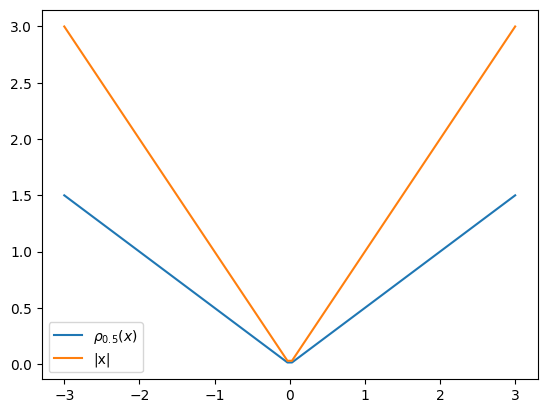

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def pinball_loss(x, tau):
    return (tau - 1 * (x <= 0)) * x

x = np.linspace(-3, 3, 100)
fig, ax = plt.subplots()
ax.plot(x, pinball_loss(x, tau=0.5), label=r"$\rho_{0.5}(x)$")
ax.plot(x, abs(x), label="|x|")
ax.legend()
fig.show()

## 分位点回帰モデル

statsmodelsでは `quantreg()` で実行できる

[Quantile regression - statsmodels 0.15.0 (+213)](https://www.statsmodels.org/devel/examples/notebooks/generated/quantile_regression.html)

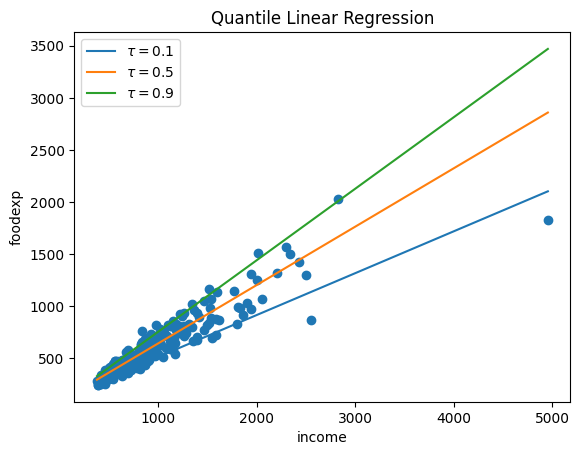

In [92]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

data = sm.datasets.engel.load_pandas().data

fig, ax = plt.subplots()
ax.scatter(data["income"], data["foodexp"])
ax.set(xlabel="income", ylabel="foodexp", title="Quantile Linear Regression")

x = np.linspace(data["income"].min(), data["income"].max(), 10)
model = smf.quantreg("foodexp ~ income", data)
for q in [0.1, 0.5, 0.9]:
    res = model.fit(q=q)
    y_hat = res.predict(pd.DataFrame({"income": x}))
    ax.plot(x, y_hat, label=fr"$\tau = {q}$")
ax.legend()
fig.show()

## LightGBMでのquantile regression

目的関数をbinball lossにすればいいだけなので他のアルゴリズムでも実行できる

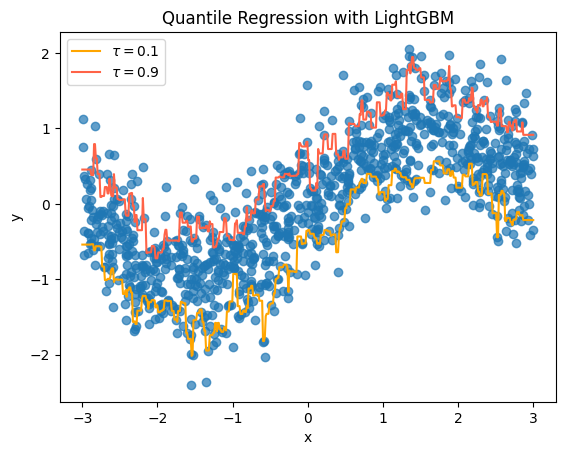

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# create data
np.random.seed(0)
n = 1000
x = np.random.uniform(-3, 3, size=n)
X = x.reshape(-1, 1)
y = np.sin(x) + np.random.normal(scale=0.5, size=n)

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.7)

# regression
x_plot = np.linspace(-3, 3, 500)
X_test = x_plot.reshape(-1, 1)
import lightgbm as lgb
taus = [0.1, 0.9]
colors = ["orange", "tomato"]
for i in range(2):
    model = lgb.LGBMRegressor(objective="quantile", alpha=taus[i], verbose=-1)
    model.fit(X, y)
    y_hat = model.predict(X_test)
    ax.plot(X_test, y_hat, color=colors[i], label=fr"$\tau = {taus[i]}$")
ax.set(xlabel="x", ylabel="y", title="Quantile Regression with LightGBM")
ax.legend()
fig.show()

## メモ：誤差と最適解

### 二乗誤差の場合

二乗誤差

$$
L(x) = (y_i - f(x))^2
$$

の場合、

$$
\begin{align}
\big(y_i - f(x)\big)^2
&= \big\{ \big(y_i - E(y|x) \big) + \big(E(y|x) - f(x) \big) \big\}^2\\
&= \big(y_i - E(y|x) \big)^2 + \big(E(y|x) - f(x) \big)^2
+ 2 \big(y_i - E(y|x) \big) \big(E(y|x) - f(x) \big)\\
\end{align}
$$

と変形すると、$E(y|x) = f(x)$のときに最小化され、予測値$f(x)$を含まない第1項のみが残ることがわかる


### 絶対誤差の場合

絶対誤差

$$
L(x) = |y_i - f(x)|
$$

[3.3. Metrics and scoring: quantifying the quality of predictions — scikit-learn 1.4.1 documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#pinball-loss)